In [88]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, accuracy_score, classification_report, r2_score as r2
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from pytorch_tabnet.tab_model import TabNetClassifier
from xgboost import XGBClassifier
import torch
import keras
from keras.constraints import max_norm as MaxNorm
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from sklearn.pipeline import make_pipeline
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

import random
random.seed(42)

In [89]:
#Importing Data
df = pd.read_csv('../Data/address_data_combined.csv')
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']
    
scaler = MinMaxScaler()

# Log for Skewed Data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [90]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(X_train_full.shape)
X_train_full.head()

(8677, 12)


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,total ether received,total ether balance
2613,628.48,672.28,4486.98,2,0.740937,6.126160,3.433549,0.000000,1.372346,7,6.867097,0.005369
9439,5.95,16359.54,540043.22,10,0.011089,99.703158,18.683700,0.534594,20.551363,63,616.562105,0.021228
2121,0.00,0.00,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
3982,0.00,0.00,2.23,1,59.995000,59.995000,59.995000,59.994528,59.994528,2,59.995000,0.000472
9985,1112.15,1644.37,717228.55,3,0.105162,31.953425,0.328026,0.000546,0.330100,520,85.614673,0.118807


In [91]:
# Feature Engineering
from sklearn.preprocessing import MinMaxScaler

columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']
    
scaler = MinMaxScaler()

# Log for Skewed Data
# log on both train and test data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
# only use training data to fit, to avoid data leakage
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [111]:
#Optimal Parameters for each model from hyperparameter tuning
tabnet_params = {'gamma': 1.0, 
                 'lambda_sparse': 0, 
                 'momentum': 0.4, 
                 'n_steps': 8, 
                 'optimizer_params': {'lr': 0.025}, 
                 'verbose': 0}

xgb_params = {'learning_rate': 0.05, 
              'max_depth': 8, 
              'n_estimators': 1000}


mlp_params = {'input_dim': X_train_full.shape[1],
              'H': 60,
              'activation': 'relu',
              'dropout_probability': 0.2,
              'num_epochs': 75,
              'num_layers': 10}

svm_params = {'C': 1000, 
              'gamma': 1}

rf_params = {'max_depth': 20, 
               'min_samples_leaf': 5,
               'n_jobs': -1}

lightgbm_params = {"bagging_fraction": 0.95, 
                   "bagging_freq": 1,
                   "feature_fraction": 0.95,
                   "learning_rate": 0.2,
                   "max_bin": 300, 
                   "max_depth": 6,
                   "min_gain_to_split": 0,
                   "num_leaves": 20}


def compile_mlp(input_dim, H, num_epochs, num_layers, activation, dropout_probability):
    # Creating Sequential MLP
    model_n = Sequential()
    model_n.add(layers.Dense(H, input_shape=(input_dim, ), activation= activation))

    for _ in range(num_layers - 1):
        model_n.add(layers.Dense(H, activation= activation, kernel_constraint=MaxNorm(3)))
        model_n.add(layers.Dropout(dropout_probability))

    model_n.add(layers.Dense(1, activation='sigmoid'))
    # configure the model
    model_n.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(from_logits=True)])
    return model_n

In [113]:
# get a list of models to evaluate
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

def get_models():
    models = dict()
    mlp = KerasClassifier(model = compile_mlp, **mlp_params)
    tabnet = TabNetClassifier(**tabnet_params)
    models['tabnet'] = tabnet
    models['svm'] = svm.SVC(**svm_params)
    models['xgboost'] = XGBClassifier(**xgb_params)
    models['mlp'] = mlp
    models['lightGBM'] = lgb.LGBMClassifier(**lightgbm_params)
    models['randomforest'] = RandomForestClassifier(**rf_params)
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)#, error_score='raise')
    return scores

>tabnet 0.905 (0.011)
>svm 0.914 (0.006)
>xgboost 0.925 (0.005)
>mlp 0.822 (0.024)
>lightGBM 0.923 (0.003)
>randomforest 0.908 (0.006)


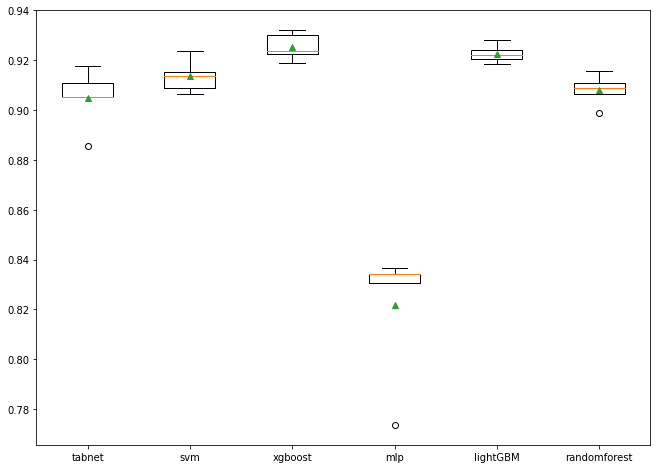

In [114]:
# define dataset
X, y = X_train_full, y_train_full
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [124]:
import warnings
warnings.filterwarnings("ignore")
import time

#Creating Stacking model - Initialized using logistic regression model
def get_stacking():
    # define the base models
    level0 = list()
    for key,value in get_models().items():
        try:
            value._estimator_type = 'classifier'
        except AttributeError:
            pass
        finally:
            level0.append([key,value])
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv= 5, n_jobs = -1)
    return model

#Pipeline to get all models
def get_models2():
    models = dict()
    models['tabnet'] = TabNetClassifier(**tabnet_params)
    models['svm'] = svm.SVC(**svm_params)
    models['xgboost'] = XGBClassifier(**xgb_params)
    models['mlp'] = KerasClassifier(model = compile_mlp, **mlp_params)
    models['lightGBM'] = lgb.LGBMClassifier()
    models['stacking'] = get_stacking()
    return models

#Getting predictions from all models to evaluate performance on test set
predictions, names2, timing_list = list(), list(), list()
for name, model in get_models2().items():
    current_time = time.time()
    model.fit(X, y)
    predictions.append(model.predict(X_test))
    names2.append(name)
    final_time = time.time()
    timing_list.append(final_time - current_time)

117/117 [==============================] - 0s 724us/step


In [125]:
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
results_df = pd.DataFrame()
results_df['Model'] = names2
results_df['Time taken'] = timing_list
results_df['Optimal Parameters'] = [tabnet_params,
                                    svm_params,
                                    xgb_params,
                                    mlp_params,
                                    lightgbm_params,
                                    None]
metrics_dict = {'Accuracy': accuracy_score, 
                'Precision': precision_score, 
                'Recall': recall_score, 
                'F1': f1_score, 
                'ROC-AUC': roc_auc_score}
for metric, func in metrics_dict.items():
    storage = []
    for prediction in predictions:
        storage.append(func(y_test, prediction))
    results_df[metric] = storage

results_df.sort_values(['Accuracy', 'ROC-AUC'], ascending = [False, False])

,Model,Time taken,Optimal Parameters,Accuracy,Precision,Recall,F1,ROC-AUC
4,lightGBM,0.106529,"{'bagging_fraction': 0.95, 'bagging_freq': 1, ...",0.953226,0.956108,0.919775,0.937590,0.946838
5,stacking,198.347178,None,0.952688,0.952070,0.922590,0.937098,0.946941
2,xgboost,2.903730,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est...",0.951882,0.954612,0.917664,0.935773,0.945348
1,svm,3.334639,"{'C': 1000, 'gamma': 1}",0.942742,0.933908,0.914849,0.924280,0.937416
0,tabnet,58.456848,"{'gamma': 1.0, 'lambda_sparse': 0, 'momentum':...",0.936559,0.940520,0.890218,0.914678,0.927710
3,mlp,1.909598,"{'input_dim': 12, 'H': 60, 'activation': 'relu...",0.887903,0.866959,0.834624,0.850484,0.877729


In [126]:
results_df.to_csv('../Data/results_with_mlp.csv')